In [16]:
#Importing necessary libraries and packages
import torch
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F, torch.backends.cudnn as cudnn 
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import random
import os

In [17]:
'''Implementation of ResNet architecture in PyTorch, with BasicBlock and Bottleneck block types.

Code reference from: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

Implements the ResNet architecture for image recognition, with pre-activation version available separately.

Referencing [1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun's Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''

import torch
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np 

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, conv_kernel_size=3, shortcut_kernel_size=1, drop=0.4):
        """
        Convolutional Layer kernel size Fi 
        Skip connection (shortcut) kernel size Ki 
        """
        super(BasicBlock, self).__init__()
        self.drop = drop 
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=conv_kernel_size, stride=stride, padding=int(conv_kernel_size/2), bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=conv_kernel_size,stride=1, padding=int(conv_kernel_size/2), bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,kernel_size=shortcut_kernel_size, stride=stride, padding=int(shortcut_kernel_size/2), bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        if self.drop: self.dropout = nn.Dropout(self.drop)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        if self.drop: out = self.dropout(out)
        return out



def conv1x1(in_channels,
            out_channels,
            stride=1,
            groups=1,
            bias=False):
    """
    Convolution 1x1 layer.
    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    """
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        groups=groups,
        bias=bias)

class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation block from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.
    Parameters:
    ----------
    channels : int
        Number of channels.
    reduction : int, default 16
        Squeeze reduction value.
    """
    def __init__(self,
                 channels,
                 reduction=16):
        super(SEBlock, self).__init__()
        mid_cannels = channels // reduction

        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv1 = conv1x1(
            in_channels=channels,
            out_channels=mid_cannels,
            bias=True)
        self.activ = nn.ReLU(inplace=True) 

        self.conv2 = conv1x1(
            in_channels=mid_cannels,
            out_channels=channels,
            bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        w = self.pool(x)
        w = self.conv1(w)
        w = self.activ(w)
        w = self.conv2(w)
        w = self.sigmoid(w)
        x = x * w
        return x

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(
            self, 
            block, 
            num_blocks, 
            conv_kernel_sizes=None, 
            shortcut_kernel_sizes=None,
            num_classes=10, 
            num_channels=32, 
            avg_pool_kernel_size=4, 
            drop=None, 
            squeeze_and_excitation=None):
        super(ResNet, self).__init__()
        self.in_planes = num_channels
        # self.avg_pool_kernel_size = avg_pool_kernel_size 
        self.avg_pool_kernel_size = int(32 / (2**(len(num_blocks)-1)))
        
        """
        # of channels Ci 
        """
        self.num_channels = num_channels
        self.conv1 = nn.Conv2d(3, self.num_channels, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.num_channels) 

        self.drop = drop 
        self.squeeze_and_excitation = squeeze_and_excitation 

        if self.squeeze_and_excitation: 
            self.seblock = SEBlock(channels=self.num_channels) 

        """
        # of Residual Layers N 
        # of Residual Blocks Bi 
        """
        self.residual_layers = [] 
        for n in range(len(num_blocks)): 
            stride = 1 if n==0 else 2 # stride=1 for first residual layer, and stride=2 for the remaining layers 
            conv_kernel_size = conv_kernel_sizes[n] if conv_kernel_sizes else 3 # setting default kernel size of block's convolutional layers 
            shortcut_kernel_size = shortcut_kernel_sizes[n] if shortcut_kernel_sizes else 1 # setting default kernel size of block's skip connection (shortcut) layers 
            self.residual_layers.append(self._make_layer(
                                                    block, 
                                                    self.num_channels*(2**n), 
                                                    num_blocks[n], 
                                                    stride=stride, 
                                                    conv_kernel_size=conv_kernel_size, 
                                                    shortcut_kernel_size=shortcut_kernel_size)) 

        self.residual_layers = nn.ModuleList(self.residual_layers)
        self.linear = nn.Linear(self.num_channels*(2**n)*block.expansion, num_classes) 
        """
        Dropout layer 
        """
        if self.drop: 
            self.dropout = nn.Dropout(self.drop) # Define proportion or neurons to dropout

    def _make_layer(self, block, planes, num_blocks, stride, conv_kernel_size, shortcut_kernel_size):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, conv_kernel_size, shortcut_kernel_size, drop=self.drop))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.squeeze_and_excitation: out = self.seblock(out) 
        for layer in self.residual_layers: 
            out = layer(out)         
        """
        Average pool kernel size 
        """
        out = F.avg_pool2d(out, self.avg_pool_kernel_size)
        out = out.view(out.size(0), -1)
        if self.drop: out = self.dropout(out)
        out = self.linear(out)
        return out


def ResNet9():
    return ResNet(BasicBlock, [2, 1, 1, 1])

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

def model(): 
    # Best Model 
    net =  ResNet(
            block=BasicBlock, 
            num_blocks=[4, 4, 3],                          # N: number of Residual Layers | Bi:Residual blocks in Residual Layer i 
            conv_kernel_sizes=[3, 3, 3],            # Fi: Conv. kernel size in Residual Layer i 
            shortcut_kernel_sizes=[1, 1, 1] ,    # Ki: Skip connection kernel size in Residual Layer i 
            num_channels=64,                      # Ci: # channels in Residual Layer i 
            avg_pool_kernel_size=8,      # P: Average pool kernel size 
            drop=0,                                      # use dropout with drop proportion 
            squeeze_and_excitation=1   # Enable/disable Squeeze-and-Excitation Block 
        ) 
    
    total_params = 0 
    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    # print("Total number of params", total_params)
    # print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters())))) 
    return net, total_params 

net, total_params = model() 
print(net)
print('Total Parameters: ', total_params) 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (seblock): SEBlock(
    (pool): AdaptiveAvgPool2d(output_size=1)
    (conv1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
    (activ): ReLU(inplace=True)
    (conv2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
    (sigmoid): Sigmoid()
  )
  (residual_layers): ModuleList(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_siz

In [10]:
#preparing data
#code: https://github.com/kuangliu/pytorch-cifar/blob/master/main.py
train_trans = [transforms.ToTensor()]
test_trans = [transforms.ToTensor()]
train_trans.append(transforms.RandomCrop(32, padding=4)) 
train_trans.append(transforms.RandomHorizontalFlip()) 
train_trans.append(transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))) 
test_trans.append(transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))) 

transform_train = transforms.Compose(train_trans) 
transform_test = transforms.Compose(test_trans) 

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=16)
testloader = torch.utils.data.DataLoader(testset, batch_size=int(128/4), shuffle=False, num_workers=16)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


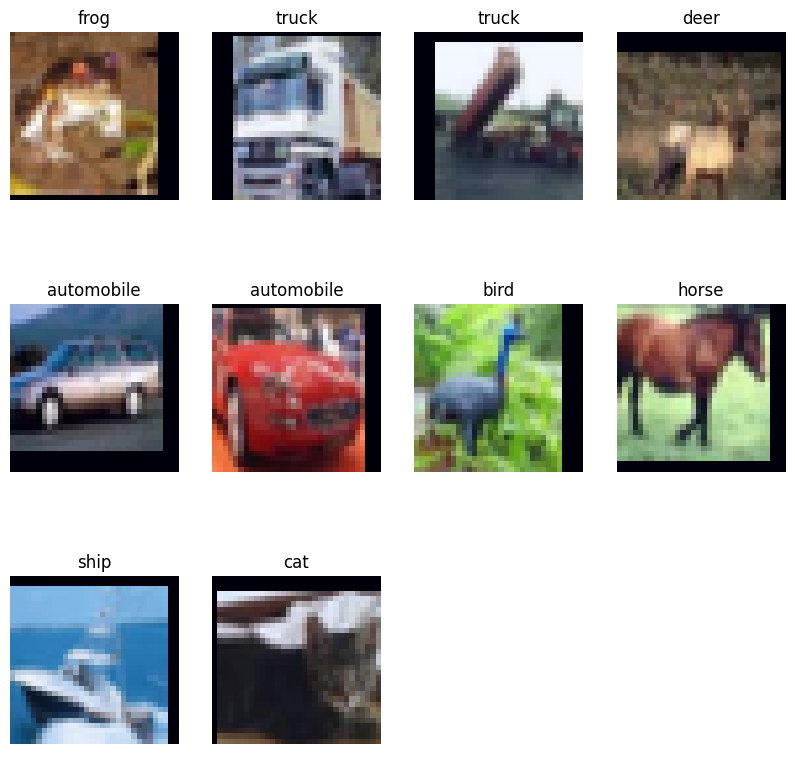

In [18]:
#plotting images

def plot_images(images, labels, classes, normalize=False):
    n_images = len(images)
    rows = int(n_images ** 0.5)
    cols = int(np.ceil(n_images / rows))
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < n_images:
            image = images[i]
            if normalize:
                image_min = image.min()
                image_max = image.max()
                image = (image - image_min) / (image_max - image_min + 1e-5)
            ax.imshow(image.permute(1, 2, 0).cpu().numpy())
            ax.set_title(classes[labels[i]])
        ax.axis('off')
N_IMAGES = 10
images, labels = zip(*[(image, label) for image, label in [trainset[i] for i in range(N_IMAGES)]])
classes = testset.classes
plot_images(images, labels, classes, normalize = True)

In [19]:
#code: https://github.com/kuangliu/pytorch-cifar/blob/master/main.py
#train function
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    train_losses = [] 
    train_acc = [] 
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_value_(net.parameters(), clip_value=0.1) 
        optimizer.step()

        train_loss += loss.item()
        train_losses.append(train_loss)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item() 

        train_acc.append(100.*correct/total) 
        print('Batch_idx: %d | Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'% (batch_idx, train_loss/(batch_idx+1), 100.*correct/total, correct, total))  

    return np.mean(train_losses),np.mean(train_acc)


In [20]:
# Testing 
#code from: https://github.com/kuangliu/pytorch-cifar/blob/master/main.py
#testing function
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    test_losses = [] 
    test_acc = [] 
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            test_losses.append(test_loss)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item() 
            test_acc.append(100.*correct/total) 
            print('Batch_idx: %d | Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'% ( batch_idx, test_loss/(batch_idx+1), 100.*correct/total, correct, total))  
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc: 
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch
        }
        torch.save(state, os.path.join('./summaries/model', 'ckpt.pth'))
        best_acc = acc
    return np.mean(test_losses),np.mean(test_acc)

In [21]:
device = 'cuda'
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [22]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005 ) 
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) # Good 

In [29]:
best_acc = 0 
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(0, 30): 
    train_l, train_a =  train(epoch) 
    train_loss.append(train_l)
    train_acc.append(train_a)
    test_l, test_a = test(epoch) 
    test_loss.append(test_l)
    test_acc.append(test_a)
    scheduler.step()


Epoch: 0


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Streaming output truncated to the last 5000 lines.
Batch_idx: 257 | Test Loss: 0.559 | Test Acc: 81.298% (6712/8256)
Batch_idx: 258 | Test Loss: 0.559 | Test Acc: 81.250% (6734/8288)
Batch_idx: 259 | Test Loss: 0.560 | Test Acc: 81.226% (6758/8320)
Batch_idx: 260 | Test Loss: 0.560 | Test Acc: 81.178% (6780/8352)
Batch_idx: 261 | Test Loss: 0.560 | Test Acc: 81.178% (6806/8384)
Batch_idx: 262 | Test Loss: 0.561 | Test Acc: 81.143% (6829/8416)
Batch_idx: 263 | Test Loss: 0.562 | Test Acc: 81.108% (6852/8448)
Batch_idx: 264 | Test Loss: 0.561 | Test Acc: 81.144% (6881/8480)
Batch_idx: 265 | Test Loss: 0.561 | Test Acc: 81.109% (6904/8512)
Batch_idx: 266 | Test Loss: 0.562 | Test Acc: 81.063% (6926/8544)
Batch_idx: 267 | Test Loss: 0.563 | Test Acc: 81.075% (6953/8576)
Batch_idx: 268 | Test Loss: 0.564 | Test Acc: 81.018% (6974/8608)
Batch_idx: 269 | Test Loss: 0.564 | Test Acc: 81.007% (6999/8640)
Batch_idx: 270 | Test Loss: 0.563 | Test Acc: 81.031% (7027/8672)
Batch_idx: 271 | Test Los

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))

plt.title('Accuracy and Loss Plots for Model')
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.plot(train_acc, label='Train Acc')  
plt.plot(test_acc, label='Test Acc')
plt.legend()
plt.xlabel("Epochs")
plt.show()

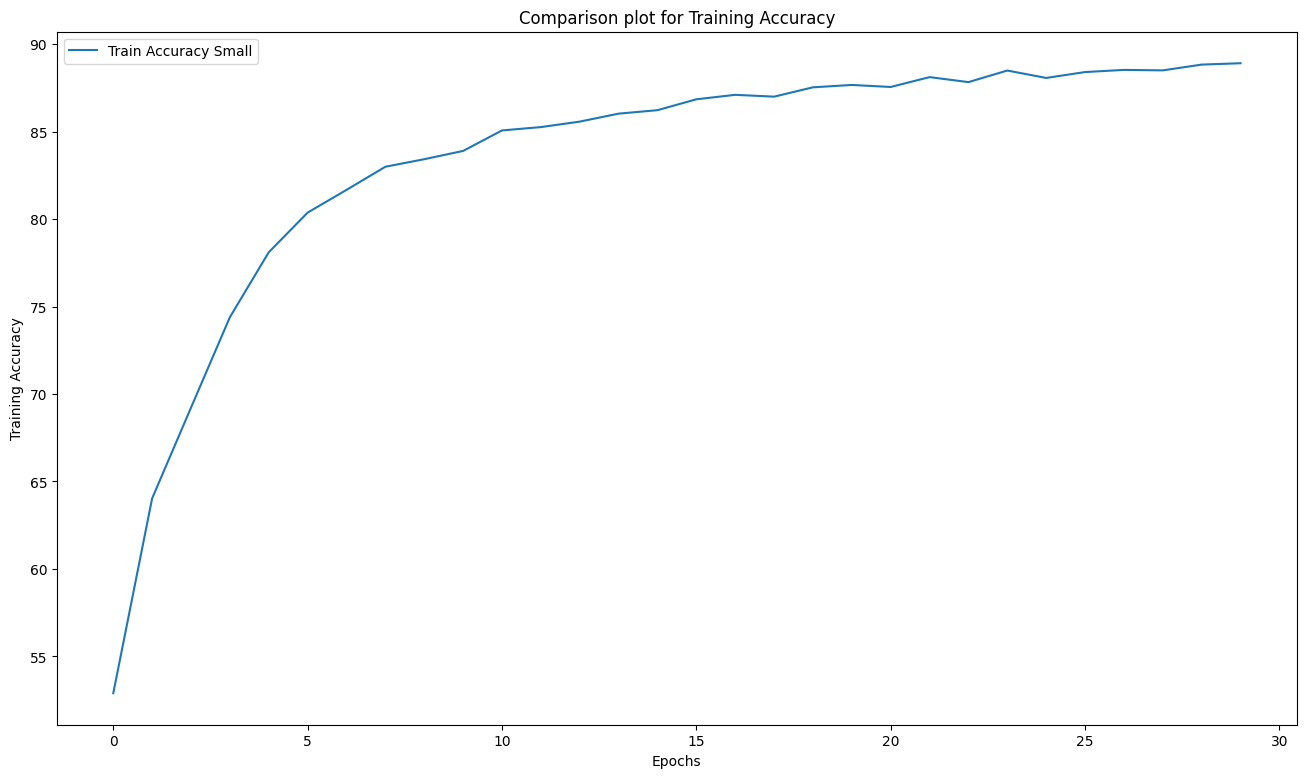

In [31]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Comparison plot for Training Accuracy')
plt.plot(train_acc, label='Train Accuracy Small')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()


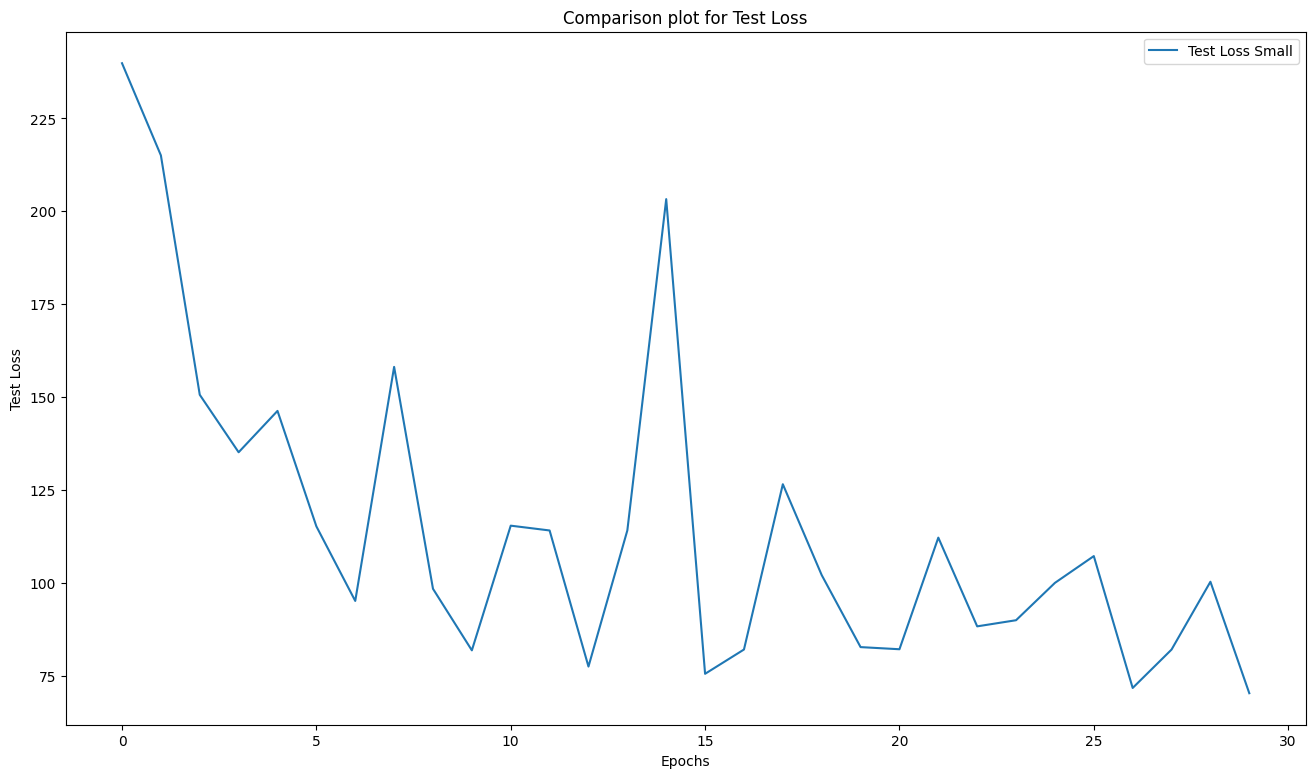

In [32]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Comparison plot for Test Loss')
plt.plot(test_loss, label='Test Loss Small')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Test Loss")
plt.show()

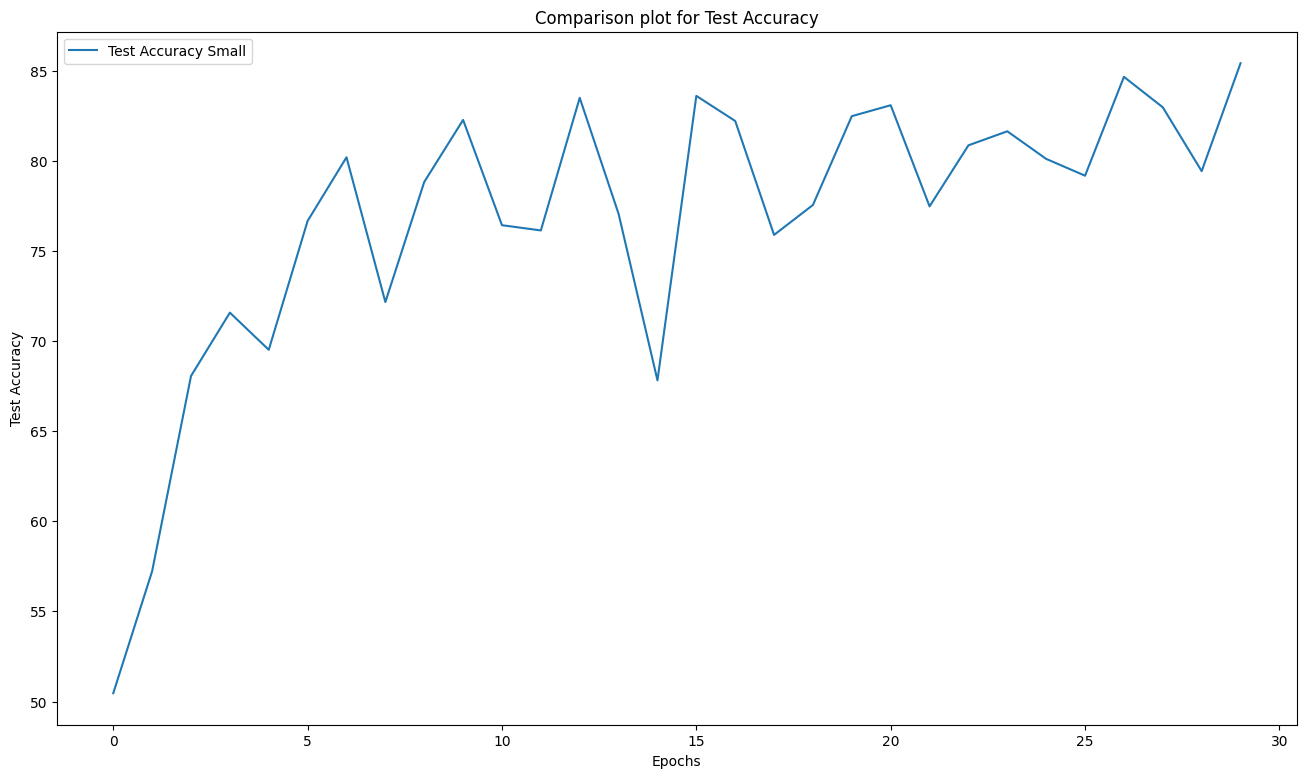

In [33]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Comparison plot for Test Accuracy')
plt.plot(test_acc, label='Test Accuracy Small')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()